# Usage of py-ciu

This notebook is included for the purpose of illustrating the use of the CIU method and hos to use the py-ciu package. The notebook is also used for generating the file "docs/py-ciu_README_notebook.html" and ensuring that all examplesexecute correctly (similarly to the "R" version of CIU, where the entire README is generated by R Studio). 

In [1]:
# Execute this if ever it's needed. But normally you would rather have cloned the source code from Github. 
# Then your working directory should be the downloaded package directory (py-ciu).
#!pip install py-ciu

Import the library:

In [2]:
# If everything is set up correctly, then this should execute fine.
import ciu as ciu
from ciu import determine_ciu
#print(ciu.__version__) # Need to add version for py-ciu package

Now, we can call the ``determine_ciu`` function which takes the following parameters:

* ``case``: A dictionary that contains the data of the case.


* ``predictor``: The prediction function of the black-box model *py-ciu* should
                 call.

* ```dataset```: Dataset to deduct min_maxs from (dictionary).
                            Defaults to ``None``.

* ``min_maxs`` (optional): dictionary (``'feature_name': [min, max, is_int]`` for each feature),
                    or infered from dataset. Defaults to ``None``
* 
* ``samples`` (optional): The number of samples *py-ciu* will generate. Defaults
                          to ``1000``.

* ``prediction_index`` (optional): In case the model returns several
                                   predictions, it is possible to provide the
                                   index of the relevant prediction. Defaults to
                                   ``None``.
                                   
* ``category_mapping`` (optional): A mapping of one-hot encoded categorical
                                   variables to lists of categories and category
                                   names. Defaults to ``None``.
                                   
* ``feature_interactions`` (optional): A list of ``{key: list}`` tuples of
                                       features whose interactions should be
                                       evaluated. Defaults to ``[]``.

Here we can use a simple example with the well known Iris flower dataset


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris=datasets.load_iris()

df = pd.DataFrame(data = np.c_[iris['data'], iris['target']],
              columns = iris['feature_names'] + ['target'])
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.columns = ['s_length', 's_width', 'p_length', 'p_width', 'target', 'species']

X = df[['s_length', 's_width', 'p_length', 'p_width']]
y = df['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

Then create and train a model, in this case an `LDA` model

In [4]:
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

Now simply use our Iris flower data and the model, following the parameter descriptions above

In [5]:
iris_df = df.apply(pd.to_numeric, errors='ignore')

iris_ciu = determine_ciu(
    X_test.iloc[[42]],
    model.predict_proba,
    iris_df.to_dict('list'),
    samples = 1000,
    prediction_index = 2
)
iris_ciu.explain_tabular()

Features,CI,CU,cmin,cmax,outval
s_length,0.000141,0.975668,9.998588e-01,1.0,0.999997
s_width,0.000235,0.985613,9.997646e-01,1.0,0.999997
p_length,1.000000,0.999997,7.110324e-19,1.0,0.999997
p_width,1.000000,0.999997,4.453536e-08,1.0,0.999997


## Boston Housing example

Let's import a test from the ciu_tests file

In [6]:
from ciu_tests.boston_gbm import get_boston_gbm_test

The ```get_boston_gbm_test``` function returns a CIU Object that we can store and use as such

In [7]:
boston_ciu = get_boston_gbm_test()
boston_ciu.explain_tabular()

Features,CI,CU,cmin,cmax,outval
CRIM,0.019517,0.001000,19.622561,19.743866,19.622561
ZN,0.103355,0.001000,19.622561,20.264963,19.622561
INDUS,0.372466,0.109379,19.369341,21.684408,19.622561
CHAS,0.000000,0.001000,19.622561,19.622561,19.622561
NOX,0.353558,0.295538,18.973103,21.170647,19.622561
RM,0.612313,0.001000,19.622561,23.428408,19.622561
AGE,0.157492,0.001000,19.622561,20.601456,19.622561
DIS,0.355974,0.323070,18.907747,21.120310,19.622561
RAD,0.000000,0.001000,19.622561,19.622561,19.622561
TAX,0.207469,1.000000,18.333031,19.622561,19.622561


Now we can also plot the CI/CU values using the CIU Object's ``plot_ciu`` function

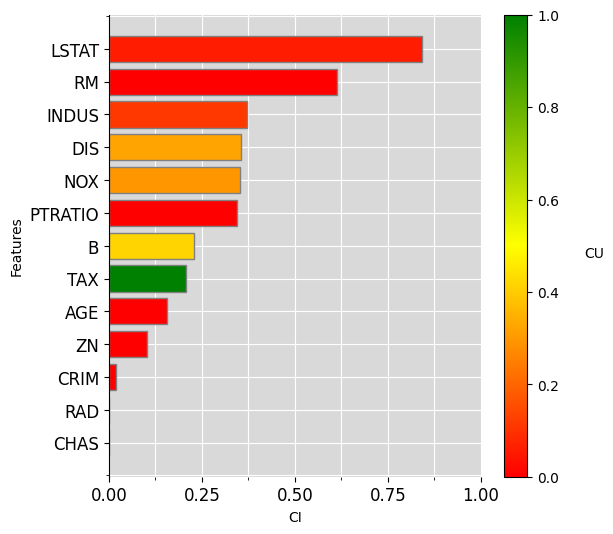

In [8]:
boston_ciu.plot_ciu() # Default plot, using colour codes

Likewise there are also several options available using the following parameters:

* ``plot_mode``: defines the type plot to use between 'default', 'overlap' and 'combined'.            
* ``include``: defines whether to include interactions or not.                                        
* ``sort``: defines the order of the plot bars by the 'ci' (default), 'cu' values or unsorted if None.
* ``color_blind``: defines accessible color maps to use for the plots, such as 'protanopia',          
                                   'deuteranopia' and 'tritanopia'.                           
* ``color_edge_cu``: defines the hex or named color for the CU edge in the overlap plot mode.         
* ``color_fill_cu``: defines the hex or named color for the CU fill in the overlap plot mode.         
* ``color_edge_ci``: defines the hex or named color for the CI edge in the overlap plot mode.         
* ``color_fill_ci``: defines the hex or named color for the CI fill in the overlap plot mode.         

Here's an example using some of these parameters to create a modified version of the above plot 

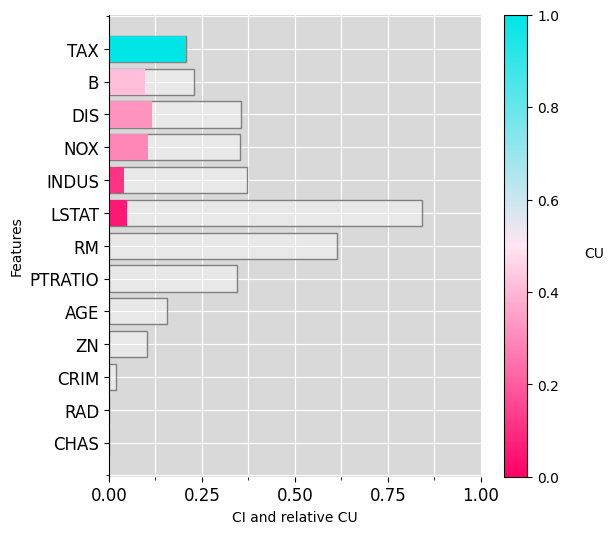

In [9]:
boston_ciu.plot_ciu(plot_mode="combined", color_blind='tritanopia', sort='cu')

## Contextual influence

Contextual influence and is calculated from CI and CU as follows:

$$
\phi_{j,\{i\},\{I\}}(x)=\omega_{j,\{i\},\{I\}}(x)(CU_{j,\{i\}}(x) - \phi_{0}),
$$

where $\phi_{0}$ is the *baseline/reference* value ($y(u(0))$ in the
plot). For instance, $\phi_{0}=0.5$ signifies using the average utility
value $0.5$ as the baseline, which is the case in the $age$ plot above.
An explanation using Contextual influence on the titanic dataset can be obtained as follows:

*Note*: the dataset and model used are not identical to the R version, 
therefore the results will see a slight variance. 

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from ciu.ciu_core import determine_ciu

data = pd.read_csv("https://raw.githubusercontent.com/KaryFramling/py-ciu/master/ciu_tests/data/titanic.csv")
data = data.drop(data.columns[0], axis=1)
unused = ['PassengerId','Cabin','Name','Ticket']

for col in unused:
    data = data.drop(col, axis=1)

from sklearn.preprocessing import LabelEncoder
data = data.dropna().apply(LabelEncoder().fit_transform)
train = data.drop('Survived', axis=1)

model = RandomForestClassifier(n_estimators=100)
model.fit(train, data.Survived)

RandomForestClassifier()

Create a new instance to explain:

In [12]:
# Create test instance (8-year old boy)
new_passenger = pd.DataFrame.from_dict({"Pclass" : [1], "Sex": [1], "Age": [8], "SibSp": [0], "Parch": [0], "Fare": [72], "Embarked": [2]})

ciu_titanic = determine_ciu(
    new_passenger,
    model.predict_proba,
    train.to_dict('list'),
    samples = 1000,
    prediction_index = 1
)

Output a bar chart using Contextual Influence:

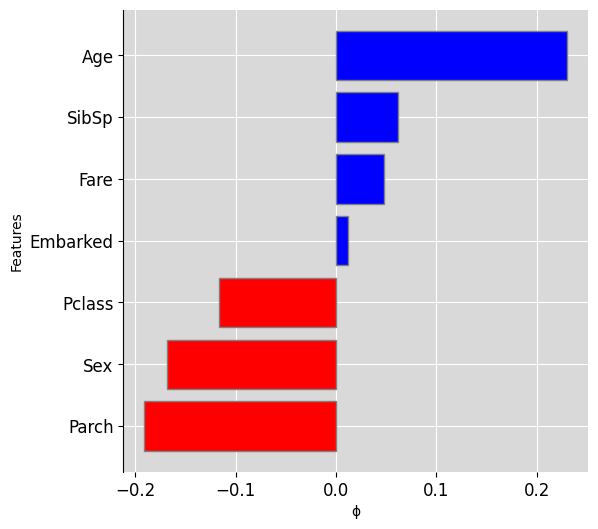

In [16]:
ciu_titanic.plot_ciu(use_influence=True)

**Remark:** The Equation for Contextual influence is similar to the
definition of Shapley values for linear models, except that the input
value $x_{i}$ is replaced by its utility value(s) $CU_{j,\{i\}}(x)$. In
practice, **all *Additive Feature Attribution (AFA)* methods estimate
influence values, not feature importance. Most state-of-the-art methods
such as *Shapley values*, *LIME*,** are AFA methods.

Influence values give no counter-factual information and are easily
misinterpreted. Below, we create a Shapley value explanation using the
IML package. In that explanation, for instance the close-to-zero Shapley
value for $Parch$ gives the impression that it’s a non-important
feature, which is clearly wrong based on the CIU explanation.

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


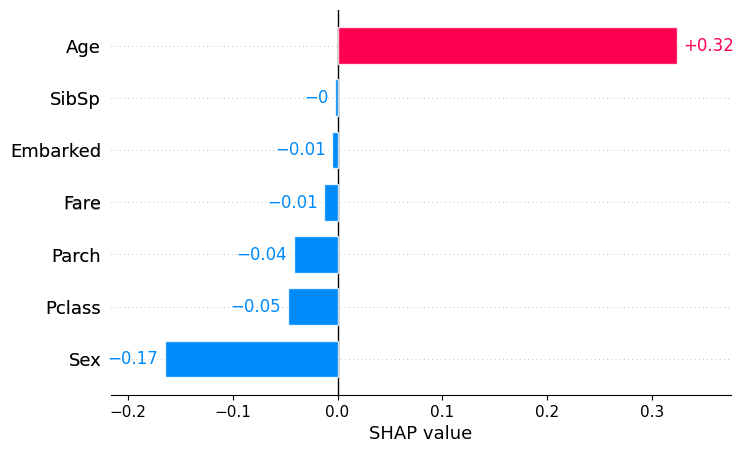

In [17]:
import shap
explainer = shap.Explainer(model, train)
shap_values = explainer(new_passenger)
shap.plots.bar(shap_values[0,:,1], order=np.argsort(shap_values[0,:,1].values)[::-1])

## Intermediate Concepts

CIU can use named feature coalitions and structured vocabularies. 
Such vocabularies allow explanations at any abstraction level and can make explanations interactive.

The following code snippet plots the joint effect of features $age$ and
$parch$ for the studied Titanic case (applicable for numeric features).
It therefore shows how the coalition of those two features affects the
output value and how CI and CU can be deduced in the same way as for a
single feature.

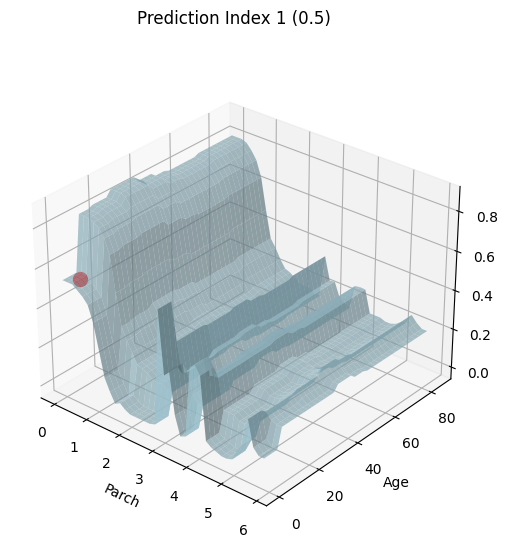

In [18]:
ciu_titanic.plot_3D(ind_inputs=[4,2])

### Titanic Example

We define a small vocabulary for Titanic as follows:

In [19]:
intermediate_tit = [
        {"Wealth":['Pclass', 'Fare']},
        {"Family":['SibSp', 'Parch']},
        {"Gender":['Sex']},
        {"Age_years":['Age']},
        {"Embarked_Place":['Embarked']}
    ]

Then we create a new CIU object that uses that vocabulary and get
top-level explanation.

In [20]:
ciu_titanic = determine_ciu(
    new_passenger,
    model.predict_proba,
    train.to_dict('list'),
    samples = 1000,
    prediction_index = 1,
    intermediate_concepts=intermediate_tit
)

First barplot explanation:

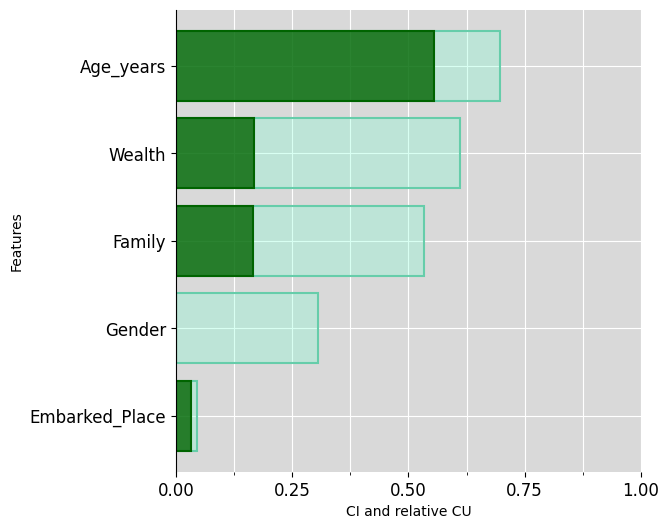

In [21]:
ciu_titanic.plot_ciu(include_intermediate_concepts='only', plot_mode='overlap')

Then explain WEALTH and FAMILY

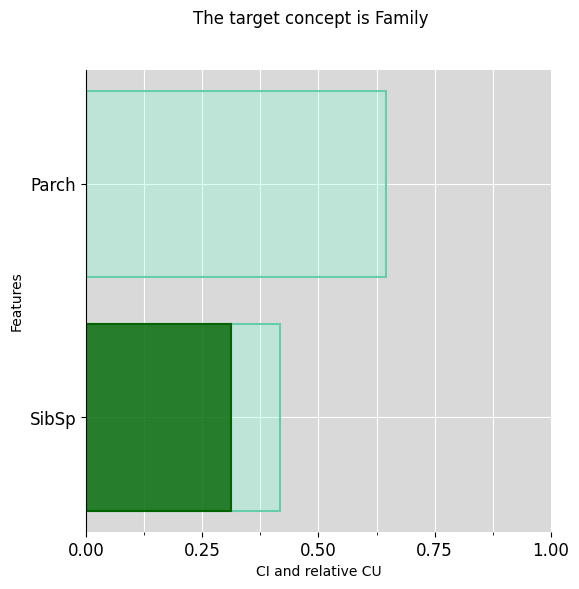

In [22]:
ciu_titanic.plot_ciu(target_concept="Family", plot_mode="overlap")

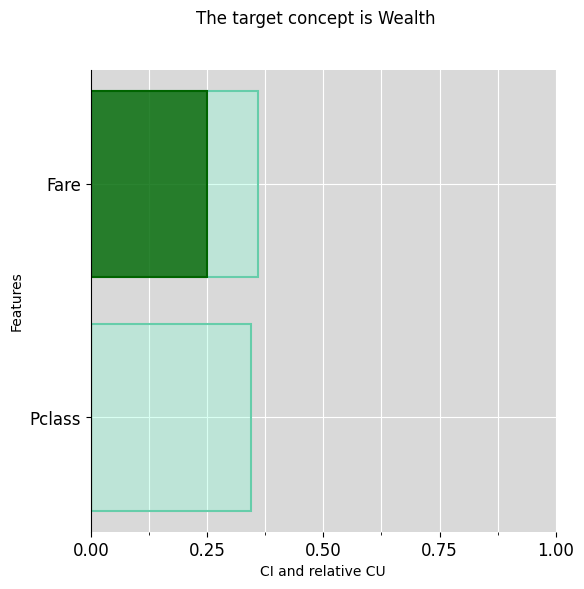

In [23]:
ciu_titanic.plot_ciu(target_concept="Wealth", plot_mode="overlap")

Same thing using textual explanations:

In [24]:
ciu_titanic.explain_text(include_intermediate_concepts="only")

['The feature "Wealth", which is of high importance (CI=61.19%), is somewhat typical for its prediction (CU=27.36%).',
 'The feature "Family", which is of normal importance (CI=53.33%), is somewhat typical for its prediction (CU=31.25%).',
 'The feature "Gender", which is of low importance (CI=30.46%), is not typical for its prediction (CU=0.1%).',
 'The feature "Age_years", which is of high importance (CI=69.63%), is very typical for its prediction (CU=79.79%).',
 'The feature "Embarked_Place", which is of very low importance (CI=4.44%), is typical for its prediction (CU=75.0%).']

In [25]:
ciu_titanic.explain_text(target_concept="Family")

['The intermediate concept "Family", is somewhat typical for its prediction (CU=31.25%).',
 'The feature "SibSp", which is of normal importance (CI=41.67%), is typical for its prediction (CU=75.0%).',
 'The feature "Parch", which is of high importance (CI=64.58%), is not typical for its prediction (CU=0.1%).']

In [26]:
ciu_titanic.explain_text(target_concept="Wealth")

['The intermediate concept "Wealth", is somewhat typical for its prediction (CU=27.36%).',
 'The feature "Pclass", which is of low importance (CI=34.5%), is not typical for its prediction (CU=0.1%).',
 'The feature "Fare", which is of low importance (CI=35.99%), is typical for its prediction (CU=69.72%).']

## Ames Housing Example

Ames housing is a data set about properties in the town Ames in the US. It contains over 80 features that can be used for learning to estimate the sales price. The following code imports the data set (make sure that you have the path to the CSV file set correctly!), does some pre-processing and trains a Gradient Boosting model:

In [28]:
from ciu.ciu_core import determine_ciu
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

df = pd.read_csv('ciu_tests/data/AmesHousing.csv')

#Checking for missing data
missing_data_count = df.isnull().sum()
missing_data_percent = df.isnull().sum() / len(df) * 100

missing_data = pd.DataFrame({
    'Count': missing_data_count,
    'Percent': missing_data_percent
})

missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)

#This one has spaces for some reason
df.columns = df.columns.str.replace(' ', '')


#Taking care of missing values
from sklearn.impute import SimpleImputer
# Group 1:
group_1 = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]
df[group_1] = df[group_1].fillna("None")

# Group 2:
group_2 = [
    'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
]

df[group_2] = df[group_2].fillna(0)

# Group 3:
group_3a = [
    'Functional', 'MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st',
    'Exterior2nd', 'SaleType', 'Utilities'
]

imputer = SimpleImputer(strategy='most_frequent')
df[group_3a] = pd.DataFrame(imputer.fit_transform(df[group_3a]), index=df.index)

df.LotFrontage = df.LotFrontage.fillna(df.LotFrontage.mean())
df.GarageYrBlt = df.GarageYrBlt.fillna(df.YearBuilt)

#Label encoding
from sklearn.preprocessing import LabelEncoder
df = df.apply(LabelEncoder().fit_transform)

data = df.drop(columns=['SalePrice'])
target = df.SalePrice

#Splitting and training
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=123)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1, max_depth = 15, alpha = 10)

xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

We start with an “explanation” using all 80 basic features, which is not very readable and overly detailed for “ordinary” humans to understand:

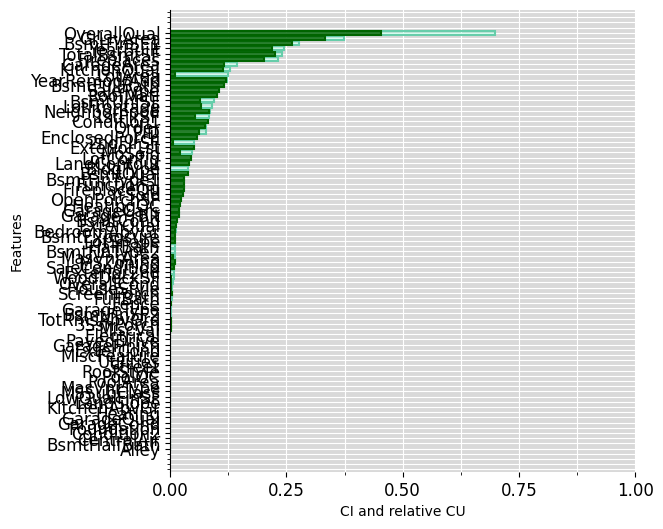

In [33]:
ciu_ames.plot_ciu(include_intermediate_concepts='no', plot_mode='overlap')

Then we create our vocabulary of intermediate concepts, in this case a list containing dictionaries of a `concept->[columns]` structure as follows:

In [29]:
intermediate = [
    {"Garage":list(df.columns[[58,59,60,61,62,63]])},
    {"Basement":list(df.columns[[30,31,33,34,35,36,37,38,47,48]])},
    {"Lot":list(df.columns[[3,4,7,8,9,10,11]])},
    {"Access":list(df.columns[[13,14]])},
    {"House_type":list(df.columns[[1,15,16,21]])},
    {"House_aesthetics":list(df.columns[[22,23,24,25,26]])},
    {"House_condition":list(df.columns[[17,18,19,20,27,28]])},
    {"First_floor_surface":list(df.columns[[43]])},
    {"Above_ground_living area":[c for c in df.columns if 'GrLivArea' in c]}
]

Now we can initialise the CIU object with a relatively expensive (which here corresponds to a "high utility") test case and our newly defined intermediate concepts:

In [32]:
test_data_ames = X_test.iloc[[345]]

ciu_ames = determine_ciu(
    test_data_ames,
    xg_reg.predict,
    df.to_dict('list'),
    samples = 1000,
    prediction_index = None,
    intermediate_concepts = intermediate
)

Then the same, using highest-level concepts:

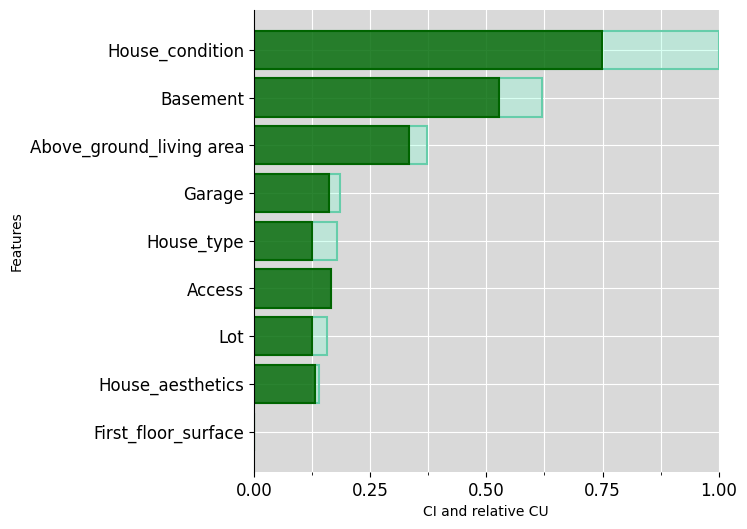

In [34]:
ciu_ames.plot_ciu(include_intermediate_concepts='only', plot_mode='overlap')

Then explain further some intermediate concepts:

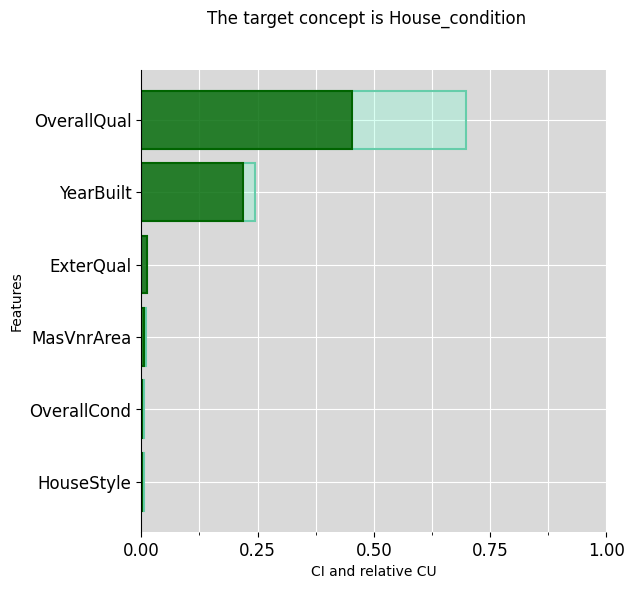

In [35]:
ciu_ames.plot_ciu(target_concept="House_condition", plot_mode="overlap")

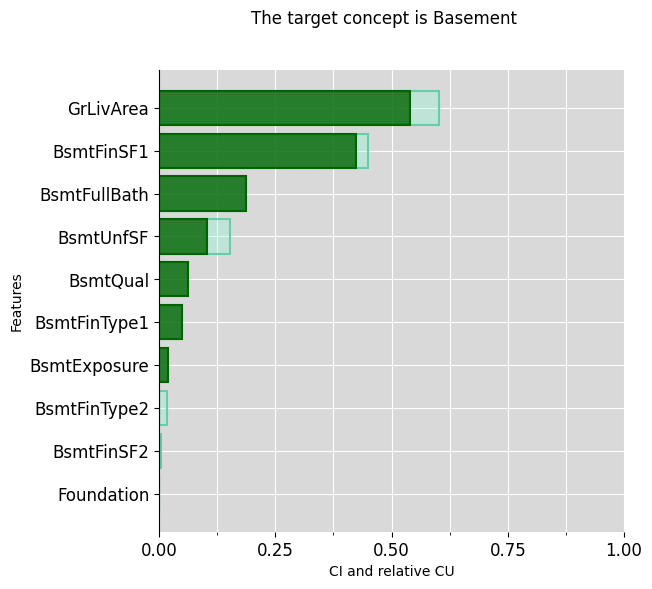

In [36]:
ciu_ames.plot_ciu(target_concept="Basement", plot_mode="overlap")

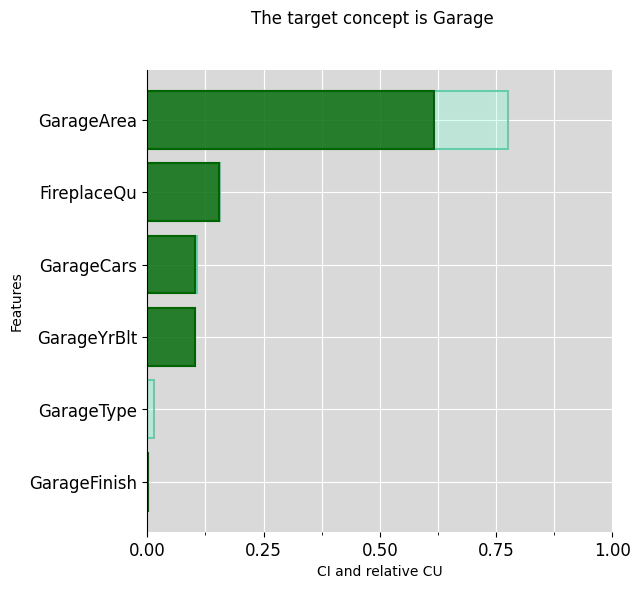

In [38]:
ciu_ames.plot_ciu(target_concept="Garage", plot_mode="overlap")

This vocabulary is just an example of what kind of concepts a human typically deals with. Vocabularies can be built freely (or learned, if possible) and used freely, even so that different vocabularies can be used with different users.